<a href="https://colab.research.google.com/github/sebasDev2001/AI-and-Data-Science-Journey/blob/main/LugsXrayFeatureExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* https://www.kaggle.com/code/rerere/nih-chest-x-rays-deep-convolutional-network
* https://www.kaggle.com/code/goldenskygiang/pvm-gaussian-lung-segmentation
* https://www.kaggle.com/code/markfsun/starter-nih-chest-x-rays-84b6a883-5
* https://www.kaggle.com/code/artyomkolas/chest-x-rays-14-diseases-14-models
* https://www.kaggle.com/code/goldenskygiang/pvm-gaussian-lung-segmentation

In [ ]:
%matplotlib inline

import numpy as np 
import pandas as pd 
#import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import zipfile
import random

import cv2
from glob import glob

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, UpSampling2D, Reshape, LeakyReLU, Conv2D,Conv2DTranspose, MaxPooling2D, Dense, Activation, Input,BatchNormalization, ReLU,GlobalAveragePooling2D, Softmax, Bidirectional, GlobalAveragePooling1D
from keras.optimizers import rmsprop_v2
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, array_to_img

from sklearn.metrics import confusion_matrix
 
from sklearn.model_selection import train_test_split

from keras.applications import vgg19, vgg16

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.applications.efficientnet import EfficientNetB0
from keras.applications.efficientnet_v2 import EfficientNetV2B0
from keras.applications.resnet_v2 import ResNet152V2, ResNet101V2, preprocess_input as PreProResNet
from tensorflow.keras.optimizers import SGD
from keras.preprocessing import image
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import callbacks
import tensorflow_datasets as tfds



np.set_printoptions(suppress=True)


Basic Image loader

In [ ]:
def read_image(file_path, ROWS = 64,COLS = 64):
  img = cv2.imread(file_path, cv2.IMREAD_COLOR)
  return cv2.resize(img, (ROWS, COLS))

def createLabels(images, filelabels, focusdisease):
  labels = np.array([])
  for img in images:
    base = os.path.basename(img)
    finding = filelabels["Finding Labels"][filelabels["Image Index"] == base].values[0]

    if focusdisease in finding:
      finding = 1
      labels = np.append(labels,finding)
    else:
      finding = 0
      labels = np.append(labels, finding)

  return labels

def prep_data(images, filelabels, focusdisease,ROWS = 64,COLS = 64,CHANNELS=3):
  labels = createLabels(images, filelabels, focusdisease)
  count = len(images)
  data = np.ndarray((count, ROWS, COLS, CHANNELS))
  for i, image_file in enumerate(images):
    image = read_image(image_file,ROWS,COLS)
    data[i] = image   
  return data, labels

Para usar la TPU


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

#NIH Dataset


In [ ]:
!unzip "drive/MyDrive/xrayslungsdataset1.zip"

In [ ]:
PATH = 'sample'

# sample/images/
SOURCE_IMAGES = os.path.join(PATH,  "images")

# sample/images/*.png
images = glob(os.path.join(SOURCE_IMAGES, "*.png"))

# Load labels
labels = pd.read_csv('sample/sample_labels.csv')
labels

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,0.139000
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,0.168000
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,0.168000
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,0.143000
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,0.168000
...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,0.194311
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,0.139000
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,0.194311
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,0.194311


In [ ]:
enfermedad = 'Effusion'
imageData, imageLabels = prep_data(images, labels, enfermedad, 224,224)
#imageData = imageData/255.0

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(imageData,imageLabels, test_size=0.2,stratify=imageLabels) #stratify es equitativo

In [ ]:
del imageData, imageLabels

In [ ]:
X_train = np.array(X_train)
X_val = np.array(X_val)
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)

In [ ]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=5, 
    width_shift_range=0.01, 
    height_shift_range=0.01, 
    fill_mode = 'constant'
)

In [ ]:
imagesTrain = datagen.flow(X_train,Y_train,)
imagesVal = datagen.flow(X_val, Y_val)

In [ ]:
del X_train, X_val, Y_train, Y_val

In [ ]:
del imagesTrain, imagesVal

Modelo con EfficientNetB0


In [ ]:
inputs = Input(shape=(224,224,3))
modelEffnetB0 = EfficientNetB0(input_tensor=inputs,include_top=False, weights='imagenet')
modelEffnetB0.trainable = False


x = GlobalAveragePooling2D(name="avg_pool")(modelEffnetB0.output)
x = BatchNormalization()(x)

x = Dropout(0.2, name="top_dropout")(x)
outputs = Dense(2, activation="softmax", name="pred")(x)
 
modelEffnetB0 = tf.keras.Model(inputs, outputs, name="EfficientNetB0")
    
 
modelEffnetB0.compile(optimizer='adam', 
                  loss = 'categorical_crossentropy',
                  metrics=[
        'accuracy',
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(multi_label = True),
        'mse'
])

In [ ]:
historyEffnetB0 = modelEffnetB0.fit(imagesTrain, validation_data=imagesVal, epochs=10, batch_size=32)

Epoch 1/10
141/141 [==============================] - 58s 368ms/step - loss: 0.5467 - accuracy: 0.7955 - recall_2: 0.1184 - auc_2: 0.4866 - mse: 0.1794 - val_loss: 0.4206 - val_accuracy: 0.8850 - val_recall_2: 0.0000e+00 - val_auc_2: 0.5000 - val_mse: 0.1225
Epoch 2/10
141/141 [==============================] - 50s 356ms/step - loss: 0.4066 - accuracy: 0.8771 - recall_2: 0.0136 - auc_2: 0.5175 - mse: 0.1189 - val_loss: 0.3711 - val_accuracy: 0.8850 - val_recall_2: 0.0000e+00 - val_auc_2: 0.4985 - val_mse: 0.1055
Epoch 3/10
141/141 [==============================] - 50s 356ms/step - loss: 0.3788 - accuracy: 0.8807 - recall_2: 0.0019 - auc_2: 0.5016 - mse: 0.1089 - val_loss: 0.3622 - val_accuracy: 0.8850 - val_recall_2: 0.0000e+00 - val_auc_2: 0.4962 - val_mse: 0.1030
Epoch 4/10
141/141 [==============================] - 50s 355ms/step - loss: 0.3737 - accuracy: 0.8834 - recall_2: 0.0058 - auc_2: 0.4976 - mse: 0.1064 - val_loss: 0.3584 - val_accuracy: 0.8850 - val_recall_2: 0.0000e+00 - 

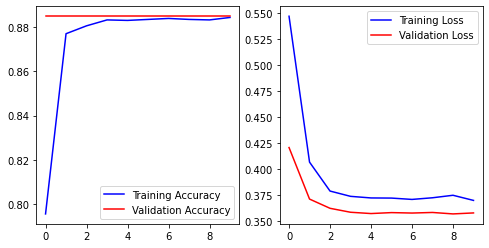

In [ ]:
showTrainStatistics(historyEffnetB0)

In [ ]:
del historyEffnetB0

Modelo Usango VGG19


In [ ]:
modelVGG19 = VGG19(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
'''
for layer in modelVGG19.layers:
  layer.trainable = False
'''
x = Flatten()(modelVGG19.output)
#x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=modelVGG19.inputs, outputs=output)

opt = SGD(learning_rate=0.001)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','mse'])

In [ ]:
history = model.fit(X_train,Y_train ,validation_data=(X_val, Y_val),epochs=15)

Epoch 1/15
141/141 [==============================] - ETA: 0s - loss: 0.3660 - accuracy: 0.8851 - mse: 0.1037

Modelo Usando uno creado previamente

In [ ]:
train_input = keras.Input(shape=(256,256,3), name='Train')
x1 = layers.Conv2D(64,(4,4),padding="same",activation="relu")(train_input)
x2 = layers.Conv2D(64,(4,4),padding="same",activation="relu")(x1)
x3 = layers.Conv2D(64,(4,4),padding="same",activation="relu")(x2)
x4 = layers.MaxPool2D(pool_size=(2,2))(x3)
x5 = layers.Dropout(0.3)(x4)
x6 = layers.Conv2D(128,(4,4),activation="relu")(x5)
x7 = layers.Conv2D(128,(4,4),activation="relu")(x6)
x8 = layers.Conv2D(128,(4,4),activation="relu")(x7)
x9 = layers.MaxPool2D(pool_size=(2,2))(x8)
x10 = layers.Conv2D(256,(4,4),activation="relu")(x9)
x11 = layers.Conv2D(256,(4,4),activation="relu")(x10)
x12 = layers.Conv2D(256,(4,4),activation="relu")(x11)
x13 = layers.Flatten()(x12)
x14 = layers.Dense(128, activation='relu')(x13)
x15 = layers.Dropout(0.2)(x14)
pred = layers.Dense(1, activation='sigmoid')(x15)
model = keras.Model(inputs=train_input,outputs=pred)
model.summary()

In [ ]:
opt = SGD(learning_rate=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy','mse'])

In [ ]:
history = model.fit(imagesTrain,validation_data=imagesVal,epochs=15)

#Pneumonia DataSet

**Cuando se quiera hacer predicciones con transfered learning, estas deben usar las funcion de preprocesamiento antes de hacer la prediccion!**

In [ ]:
!unzip "drive/MyDrive/archive.zip"

In [ ]:
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"
val_dir = "chest_xray/val"

In [ ]:
trainImages.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
#ver un batch de imagenes
sample, labels = next(trainImages)

sample.shape

(32, 224, 224, 3)

In [ ]:
def plotimg(imgs):
  fig, axes = plt.subplots(1,10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(imgs, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

def matrixConfusion(cm) :  
  plt.figure(figsize=(4,4))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = ['NORMAL','PNEUMONIA']
  plt.title('Confusion Matrix')
  plt.ylabel('Clase real')
  plt.xlabel('Predicción')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),ha="center", va="center")
          plt.rcParams["axes.grid"] = False
  plt.show()

def showTrainStatistics(modelHistory):
  acc=modelHistory.history['accuracy']
  val_acc=modelHistory.history['val_accuracy']
  epoch=range(len(acc))
  loss=modelHistory.history['loss']
  val_loss=modelHistory.history['val_loss']
  f,ax=plt.subplots(1,2,figsize=(8,4))
  ax[0].plot(epoch,acc,'blue',label='Training Accuracy')
  ax[0].plot(epoch,val_acc,'red',label='Validation Accuracy')
  ax[0].legend()
  ax[1].plot(epoch,loss,'blue',label='Training Loss')
  ax[1].plot(epoch,val_loss,'red',label='Validation Loss')
  ax[1].legend()
  plt.show()

def getPredLabelsBinary(predictions):
  prediction_labels = []
  for i in predictions:
    if i>0.5:
      prediction_labels.append('PNEUMONIA')
    else:
      prediction_labels.append('NORMAL')
  return prediction_labels

def getPredLabelsCategorical(predictions):
  prediction_labels = []
  for i in predictions:
    choice = np.argmax(i)
    prediction_labels.append('PNEUMONIA' if choice else 'NORMAL')
  return prediction_labels



# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=5)

##Model 1

In [ ]:
img_Datagen = ImageDataGenerator(
        rescale = 1.0/255.0,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
)
val_Datagen = ImageDataGenerator(
        rescale = 1./255.0,
)

pred_Datagen = ImageDataGenerator(
        rescale = 1./255.0,
        preprocessing_function=keras.applications.vgg19.preprocess_input
)


In [ ]:
trainImages = img_Datagen.flow_from_directory(directory=train_dir, target_size=(224,224),class_mode='categorical', batch_size=32)
testImages = val_Datagen.flow_from_directory(directory=test_dir, target_size=(224,224),class_mode='categorical', batch_size=32)
valImages = val_Datagen.flow_from_directory(directory=val_dir,class_mode='categorical', target_size=(224,224), shuffle=False)
predImages = pred_Datagen.flow_from_directory(directory=test_dir, target_size=(224,224),class_mode='categorical', batch_size=32)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
model = VGG19(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
for layer in model.layers:
  layer.trainable = False
x = Flatten()(model.output)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=model.inputs, outputs=output)

opt = keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy',
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC(multi_label = True),
                        'mse'])

80150528/80134624 [==============================] - 3s 0us/step


In [ ]:
history = model.fit(trainImages,
                    epochs=20, 
                    validation_data=testImages,
                    steps_per_epoch=len(trainImages),
                    validation_steps=len(testImages),
                    callbacks=[early_stopping,lr],
                    verbose=True,)

Epoch 1/20
163/163 [==============================] - 121s 645ms/step - loss: 0.2954 - accuracy: 0.8907 - recall: 0.8907 - auc: 0.9374 - mse: 0.0821 - val_loss: 0.4943 - val_accuracy: 0.8301 - val_recall: 0.8301 - val_auc: 0.9483 - val_mse: 0.1343 - lr: 0.0010
Epoch 2/20
163/163 [==============================] - 104s 639ms/step - loss: 0.1397 - accuracy: 0.9434 - recall: 0.9434 - auc: 0.9838 - mse: 0.0412 - val_loss: 0.3372 - val_accuracy: 0.8830 - val_recall: 0.8830 - val_auc: 0.9558 - val_mse: 0.0896 - lr: 0.0010
Epoch 3/20
163/163 [==============================] - 103s 631ms/step - loss: 0.1379 - accuracy: 0.9463 - recall: 0.9463 - auc: 0.9833 - mse: 0.0390 - val_loss: 0.2285 - val_accuracy: 0.9231 - val_recall: 0.9231 - val_auc: 0.9639 - val_mse: 0.0613 - lr: 0.0010
Epoch 4/20
163/163 [==============================] - 101s 618ms/step - loss: 0.1144 - accuracy: 0.9571 - recall: 0.9571 - auc: 0.9888 - mse: 0.0330 - val_loss: 0.2470 - val_accuracy: 0.9103 - val_recall: 0.9103 - val

In [ ]:
score = model.evaluate(testImages)

20/20 [==============================] - 6s 279ms/step - loss: 0.2863 - accuracy: 0.9167 - recall: 0.9167 - auc: 0.9562 - mse: 0.0690


Text(0.5, 1.0, 'Accuracy Evolution')

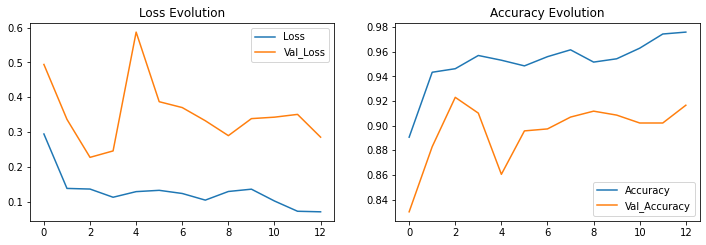

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('EVALUATION OF VGG19')

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

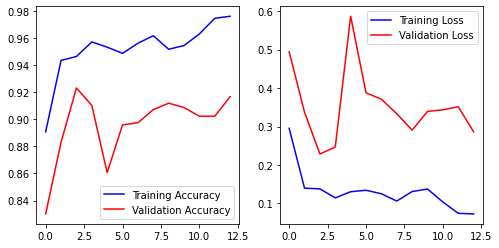

In [ ]:
showTrainStatistics(history)

In [ ]:
predictions = model.predict(predImages)
predLabels = getPredLabelsCategorical(predictions)

In [ ]:
predLabels

In [ ]:
real_labels = [('PNEUMONIA' if i == 1 else 'NORMAL') for i in testImages.classes]


In [ ]:

cm = confusion_matrix(real_labels, predLabels)

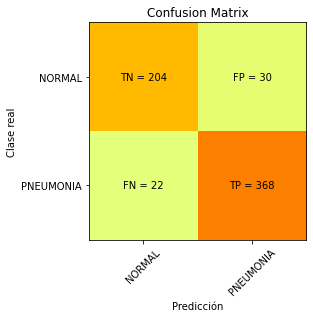

In [ ]:
matrixConfusion(cm)

In [ ]:
model.save('modelVGG19.h5')

##Model 2


In [ ]:
img_Datagen = ImageDataGenerator(
        preprocessing_function=keras.applications.efficientnet.preprocess_input,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
)
val_Datagen = ImageDataGenerator(
        preprocessing_function=keras.applications.efficientnet.preprocess_input
)

pred_Datagen = ImageDataGenerator(
        preprocessing_function=keras.applications.efficientnet.preprocess_input
)

In [ ]:
trainImages = img_Datagen.flow_from_directory(directory=train_dir, target_size=(256,256),class_mode='categorical', batch_size=64)
testImages = val_Datagen.flow_from_directory(directory=test_dir, target_size=(256,256),class_mode='categorical', batch_size=64)
valImages = val_Datagen.flow_from_directory(directory=val_dir,class_mode='categorical', target_size=(256,256), shuffle=False)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:

modelEffnetB0 = EfficientNetB0(input_shape=(256,256,3),include_top=False, weights='imagenet')
modelEffnetB0.trainable = False


x = Flatten(name="avg_pool")(modelEffnetB0.output)
x = Dense(512, activation='relu')(x)
outputs = Dense(2, activation="softmax", name="pred")(x)
 
modelEffnetB0 = tf.keras.Model(modelEffnetB0.inputs, outputs, name="EfficientNetB0")
    
 
modelEffnetB0.compile(optimizer='adam', 
                  loss = 'categorical_crossentropy',
                  metrics=[
        'accuracy',
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(multi_label = True),
        'mse'
])
#modelEffnetB0.summary()

In [ ]:
history = modelEffnetB0.fit(trainImages,epochs=15, 
                    validation_data=testImages,
                    steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    verbose=True)

Epoch 1/15
100/100 [==============================] - 119s 1s/step - loss: 2.2976 - accuracy: 0.9126 - recall_17: 0.9126 - auc_17: 0.9115 - mse: 0.0818 - val_loss: 1.0182 - val_accuracy: 0.8686 - val_recall_17: 0.8686 - val_auc_17: 0.8958 - val_mse: 0.1199 - lr: 0.0010


In [ ]:
predictions = modelEffnetB0.predict(testImages)
 predLabels = getPredLabels(predictions)

In [ ]:
predictions.mean()

0.8047577

In [ ]:
real_labels = [('PNEUMONIA' if i == 1 else 'NORMAL') for i in testImages.classes]

In [ ]:
cm = confusion_matrix(real_labels, predLabels)


In [ ]:
cm

array([[  0, 234],
       [  0, 390]])

##Model 3

In [ ]:
num_clases = 2


model = Sequential()
model.add(Conv2D(6, (5, 5), input_shape=(32, 32, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(16, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
'''model.add(Dropout(0.2))
model.add(Conv2D(20, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
'''

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(num_clases, activation='softmax'))

opt = SGD(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt , metrics=['accuracy', 'mse'])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 14, 14, 6)        0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 14, 14, 6)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 5, 5, 16)         0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 5, 5, 16)         

In [ ]:
resultModel1 = model.fit(trainImages, validation_data=valImages, epochs=10)

Epoch 1/10
163/163 [==============================] - 51s 309ms/step - loss: 0.5815 - accuracy: 0.7343 - mse: 0.1966 - val_loss: 0.7539 - val_accuracy: 0.5000 - val_mse: 0.2783
Epoch 2/10
163/163 [==============================] - 51s 313ms/step - loss: 0.5321 - accuracy: 0.7429 - mse: 0.1759 - val_loss: 0.7416 - val_accuracy: 0.5000 - val_mse: 0.2726
Epoch 3/10
163/163 [==============================] - 51s 311ms/step - loss: 0.4526 - accuracy: 0.7690 - mse: 0.1434 - val_loss: 0.7138 - val_accuracy: 0.5625 - val_mse: 0.2598
Epoch 4/10
163/163 [==============================] - 50s 309ms/step - loss: 0.3433 - accuracy: 0.8714 - mse: 0.1008 - val_loss: 0.6788 - val_accuracy: 0.5625 - val_mse: 0.2434
Epoch 5/10
163/163 [==============================] - 50s 310ms/step - loss: 0.2586 - accuracy: 0.9128 - mse: 0.0730 - val_loss: 0.7104 - val_accuracy: 0.5625 - val_mse: 0.2546
Epoch 6/10
163/163 [==============================] - 50s 308ms/step - loss: 0.2171 - accuracy: 0.9212 - mse: 0.062

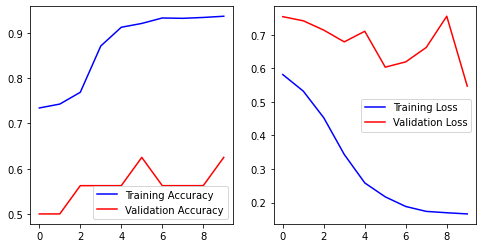

In [ ]:
showTrainStatistics(resultModel1)

In [ ]:
model.evaluate(testImages)

20/20 [==============================] - 5s 262ms/step - loss: 0.4637 - accuracy: 0.7901 - mse: 0.1458


[0.4637388586997986, 0.7900640964508057, 0.1458301544189453]

##Model 4

In [ ]:
trainImages = img_Datagen.flow_from_directory(directory=train_dir, target_size=(512,512),class_mode='binary', batch_size=16)
testImages = val_Datagen.flow_from_directory(directory=test_dir, target_size=(512,512),class_mode='binary', batch_size=16)
valImages = val_Datagen.flow_from_directory(directory=val_dir,class_mode='binary', shuffle=False)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
train_input = keras.Input(shape=(512,512,3), name='Train')
x1 = layers.Conv2D(32,(3,3),padding="same",activation="relu")(train_input)
x2 = layers.Conv2D(32,(3,3),padding="same",activation="relu")(x1)
x3 = layers.Conv2D(32,(3,3),padding="same",activation="relu")(x2)
x4 = layers.MaxPool2D(pool_size=(2,2))(x3)
x5 = layers.Dropout(0.2)(x4)
x6 = layers.Conv2D(64,(3,3),activation="relu")(x5)
x7 = layers.Conv2D(64,(3,3),activation="relu")(x6)
x8 = layers.Conv2D(64,(3,3),activation="relu")(x7)
x9 = layers.MaxPool2D(pool_size=(2,2))(x8)
x10 = layers.Conv2D(128,(3,3),activation="relu")(x9)
x11 = layers.Conv2D(128,(3,3),activation="relu")(x10)
x12 = layers.Conv2D(128,(3,3),activation="relu")(x11)
x13 = layers.MaxPool2D(pool_size=(2,2))(x12)
x14 = layers.Flatten()(x13)
x15 = layers.Dense(128, activation='relu')(x14)
pred = layers.Dense(1, activation='softmax')(x15)
model1 = keras.Model(inputs=train_input,outputs=pred)
model1.summary()

In [ ]:
opt = SGD(learning_rate=0.01,momentum=0.01)
model1.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy','mse'])

In [ ]:
history = model1.fit(trainImages,validation_data=valImages,epochs=20)

##Model 5


In [ ]:
img_Datagen = ImageDataGenerator(
        rescale = 1.0/255.0,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
)
val_Datagen = ImageDataGenerator(
        rescale = 1./255.0,
)

pred_Datagen = ImageDataGenerator(
        rescale = 1./255.0,
        preprocessing_function=keras.applications.vgg16.preprocess_input
)


In [ ]:
trainImages = img_Datagen.flow_from_directory(directory=train_dir, target_size=(224,224),class_mode='categorical', batch_size=32)
testImages = val_Datagen.flow_from_directory(directory=test_dir, target_size=(224,224),class_mode='categorical', batch_size=32)
valImages = val_Datagen.flow_from_directory(directory=val_dir,class_mode='categorical', target_size=(224,224), shuffle=False)
predImages = pred_Datagen.flow_from_directory(directory=test_dir, target_size=(224,224),class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
modelVGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in modelVGG16.layers:
  layer.trainable = False

x = Flatten()(modelVGG16.output)

output = Dense(2, activation='softmax')(x)

modelVGG16 = Model(inputs=modelVGG16.inputs, outputs=output)

modelVGG16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(multi_label = True),
        'mse'])
#model2.summary()

58900480/58889256 [==============================] - 2s 0us/step


In [ ]:
history = modelVGG16.fit(trainImages,epochs=15, 
                    validation_data=testImages,
                    steps_per_epoch=len(trainImages),
                    validation_steps=len(testImages),
                    callbacks=[early_stopping,lr],
                    verbose=True,)

Epoch 1/15
163/163 [==============================] - 103s 623ms/step - loss: 0.2296 - accuracy: 0.9151 - recall_1: 0.9151 - auc_1: 0.9543 - mse: 0.0651 - val_loss: 0.2843 - val_accuracy: 0.9006 - val_recall_1: 0.9006 - val_auc_1: 0.9565 - val_mse: 0.0783 - lr: 0.0010
Epoch 2/15
163/163 [==============================] - 101s 619ms/step - loss: 0.1251 - accuracy: 0.9542 - recall_1: 0.9542 - auc_1: 0.9864 - mse: 0.0349 - val_loss: 0.2614 - val_accuracy: 0.9119 - val_recall_1: 0.9119 - val_auc_1: 0.9569 - val_mse: 0.0720 - lr: 0.0010
Epoch 3/15
163/163 [==============================] - 101s 621ms/step - loss: 0.1343 - accuracy: 0.9492 - recall_1: 0.9492 - auc_1: 0.9859 - mse: 0.0383 - val_loss: 0.3144 - val_accuracy: 0.8942 - val_recall_1: 0.8942 - val_auc_1: 0.9498 - val_mse: 0.0827 - lr: 0.0010
Epoch 4/15
163/163 [==============================] - 100s 616ms/step - loss: 0.1253 - accuracy: 0.9553 - recall_1: 0.9553 - auc_1: 0.9861 - mse: 0.0340 - val_loss: 0.4188 - val_accuracy: 0.881

In [ ]:
modelVGG16.evaluate(testImages)

20/20 [==============================] - 6s 269ms/step - loss: 0.3333 - accuracy: 0.9038 - recall_1: 0.9038 - auc_1: 0.9509 - mse: 0.0805


[0.3333159387111664,
 0.9038461446762085,
 0.9038461446762085,
 0.9508875012397766,
 0.08054179698228836]

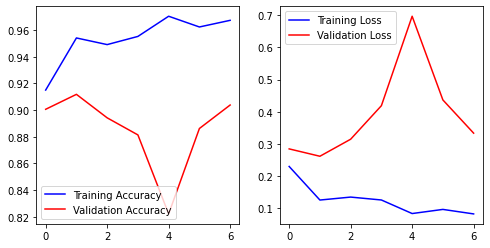

In [ ]:
showTrainStatistics(history)

In [ ]:
predictions = modelVGG16.predict(predImages)
predLabels = getPredLabelsCategorical(predictions
                                      )

In [ ]:
predLabels

In [ ]:
real_labels = [('PNEUMONIA' if i == 1 else 'NORMAL') for i in testImages.classes]


In [ ]:
real_labels

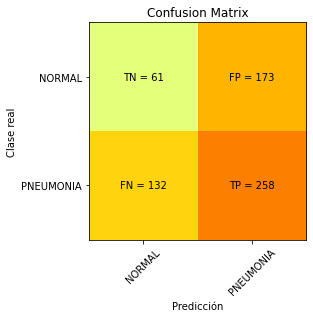

In [ ]:
cm = confusion_matrix(real_labels, predLabels)
matrixConfusion(cm)

## Model 6


In [ ]:
img_Datagen = ImageDataGenerator(
        rescale = 1.0/255.0,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
)
val_Datagen = ImageDataGenerator(
        rescale = 1./255.0,
)

pred_Datagen = ImageDataGenerator(
        rescale = 1./255.0,
        preprocessing_function=keras.applications.densenet.preprocess_input
)

In [ ]:
trainImages = img_Datagen.flow_from_directory(directory=train_dir, target_size=(256,256),class_mode='categorical', batch_size=32)
testImages = val_Datagen.flow_from_directory(directory=test_dir, target_size=(256,256),class_mode='categorical', batch_size=32)
valImages = val_Datagen.flow_from_directory(directory=val_dir,class_mode='categorical', target_size=(256,256), shuffle=False)
predImages = pred_Datagen.flow_from_directory(directory=test_dir, target_size=(256,256),class_mode='categorical', batch_size=32)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
from keras.applications.densenet import DenseNet121

orig_net = DenseNet121(include_top=False, weights='imagenet', input_shape=(256,256,3)) 

x = Flatten()(orig_net.output)
#x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

orig_net = Model(inputs=orig_net.inputs, outputs=output)

opt = SGD(learning_rate=0.001)
orig_net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(multi_label = True),
        'mse'])

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
history = orig_net.fit(trainImages,epochs=10, 
                    validation_data=testImages,
                    steps_per_epoch=len(trainImages),
                    validation_steps=len(testImages),
                    callbacks=[early_stopping,lr],
                    verbose=True,)

Epoch 1/10
163/163 [==============================] - 143s 777ms/step - loss: 0.5325 - accuracy: 0.8892 - recall_6: 0.8892 - auc_6: 0.9315 - mse: 0.0890 - val_loss: 691.8469 - val_accuracy: 0.6250 - val_recall_6: 0.6250 - val_auc_6: 0.5000 - val_mse: 0.3750 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 119s 727ms/step - loss: 0.2237 - accuracy: 0.9227 - recall_6: 0.9227 - auc_6: 0.9646 - mse: 0.0603 - val_loss: 0.5623 - val_accuracy: 0.7708 - val_recall_6: 0.7708 - val_auc_6: 0.9377 - val_mse: 0.1700 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 118s 720ms/step - loss: 0.9035 - accuracy: 0.8806 - recall_6: 0.8806 - auc_6: 0.9119 - mse: 0.0974 - val_loss: 11976.8379 - val_accuracy: 0.6170 - val_recall_6: 0.6170 - val_auc_6: 0.4936 - val_mse: 0.3830 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 118s 722ms/step - loss: 2.5441 - accuracy: 0.8439 - recall_6: 0.8439 - auc_6: 0.8600 - mse: 0.1373 - val_loss: 2.1967 - val_accuracy:

In [ ]:
orig_net.evaluate(testImages)

20/20 [==============================] - 6s 275ms/step - loss: 27.3027 - accuracy: 0.8093 - recall_6: 0.8093 - auc_6: 0.8772 - mse: 0.1613


[27.302705764770508,
 0.8092948794364929,
 0.8092948794364929,
 0.8771641850471497,
 0.16132211685180664]

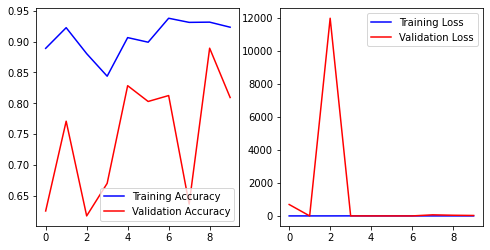

In [ ]:
showTrainStatistics(history)

In [ ]:
predictions = orig_net.predict(predImages)
predLabels = getPredLabelsCategorical(predictions)

In [ ]:
predLabels

In [ ]:
real_labels = [('PNEUMONIA' if i == 1 else 'NORMAL') for i in testImages.classes]


In [ ]:

cm = confusion_matrix(real_labels, predLabels)

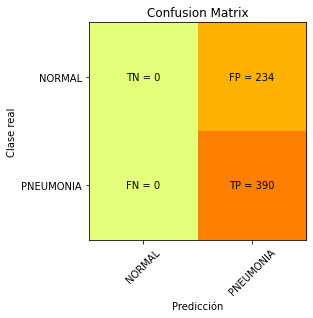

In [ ]:
matrixConfusion(cm)

##Model 7


In [ ]:
img_Datagen = ImageDataGenerator(
        rescale = 1.0/255.0,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
)
val_Datagen = ImageDataGenerator(
        rescale = 1./255.0,
)

pred_Datagen = ImageDataGenerator(
        rescale = 1./255.0,
        preprocessing_function=keras.applications.resnet_v2.preprocess_input
)

In [ ]:
trainImages = img_Datagen.flow_from_directory(directory=train_dir, target_size=(224,224),class_mode='categorical', batch_size=32)
testImages = val_Datagen.flow_from_directory(directory=test_dir, target_size=(224,224),class_mode='categorical', batch_size=32)
valImages = val_Datagen.flow_from_directory(directory=val_dir,class_mode='categorical', target_size=(224,224), shuffle=False)
predImages = pred_Datagen.flow_from_directory(directory=test_dir, target_size=(224,224),class_mode='categorical', batch_size=32)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
resnet_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    layer.trainable=False
    
x = resnet_model.output
x = Flatten()(x)
# output layer
predictions = tf.keras.layers.Dense(2,activation='softmax')(x)

modelResNet = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

modelResNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','Precision','mse'])

In [ ]:
history = modelResNet.fit(trainImages,epochs=10, 
                    validation_data=testImages,
                    steps_per_epoch=len(trainImages),
                    validation_steps=len(testImages),
                    callbacks=[early_stopping,lr],
                    verbose=True,)

Epoch 1/10
163/163 [==============================] - 105s 617ms/step - loss: 1.2820 - accuracy: 0.9170 - precision: 0.9170 - mse: 0.0784 - val_loss: 2.0804 - val_accuracy: 0.8782 - val_precision: 0.8782 - val_mse: 0.1143 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 99s 604ms/step - loss: 0.8605 - accuracy: 0.9398 - precision: 0.9398 - mse: 0.0564 - val_loss: 2.4992 - val_accuracy: 0.9006 - val_precision: 0.9006 - val_mse: 0.0965 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 98s 603ms/step - loss: 0.9328 - accuracy: 0.9469 - precision: 0.9469 - mse: 0.0509 - val_loss: 4.8422 - val_accuracy: 0.8269 - val_precision: 0.8269 - val_mse: 0.1721 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 98s 600ms/step - loss: 0.9153 - accuracy: 0.9526 - precision: 0.9526 - mse: 0.0459 - val_loss: 1.8357 - val_accuracy: 0.9167 - val_precision: 0.9167 - val_mse: 0.0802 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - 97s 598ms

In [ ]:
modelResNet.evaluate(testImages)

20/20 [==============================] - 6s 305ms/step - loss: 3.3713 - accuracy: 0.9199 - precision: 0.9199 - mse: 0.0779


[3.3712525367736816,
 0.9198718070983887,
 0.9198718070983887,
 0.07793734967708588]

In [ ]:
predictions = modelResNet.predict(predImages)
predLabels = getPredLabelsCategorical(predictions)

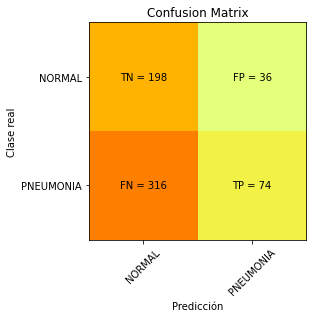

In [ ]:
cm = confusion_matrix(real_labels, predLabels)
matrixConfusion(cm)

##Model 8


In [ ]:
img_Datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='constant'
        
)
val_Datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        fill_mode='constant'
)

pred_Datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        fill_mode='constant'
)


In [ ]:
trainImages = img_Datagen.flow_from_directory(directory=train_dir, target_size=(512,512),class_mode='categorical')
testImages = val_Datagen.flow_from_directory(directory=test_dir, target_size=(512,512),class_mode='categorical')
valImages = val_Datagen.flow_from_directory(directory=val_dir,class_mode='categorical', target_size=(512,512))
predImages = pred_Datagen.flow_from_directory(directory=test_dir, target_size=(512,512),class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


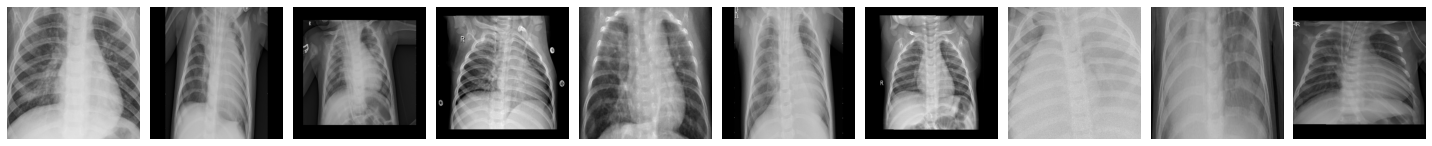

In [ ]:
plotimg(next(trainImages)[0])

In [ ]:
def createModel8(model):
  model.add(Conv2D(32,kernel_size=(3,3), activation='relu', padding='same', input_shape=(512,512,3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64,(3,3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64,(3,3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128,(3,3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128,(3,3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(256,(3,3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(256,(3,3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(2, activation='softmax'))

  model.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy',
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC(multi_label = True),
                        'mse'])



In [ ]:
model8 = Sequential()
createModel8(model8)
model8.summary()

In [ ]:
history = model8.fit(trainImages,
                    epochs=15, 
                    validation_data=testImages,
                    steps_per_epoch=len(trainImages),
                    validation_steps=len(testImages),
                    callbacks=[early_stopping,lr],
                    verbose=True)

Epoch 1/15
163/163 [==============================] - 277s 2s/step - loss: 3.9584 - accuracy: 0.8687 - recall_2: 0.8687 - auc_2: 0.8711 - mse: 0.1148 - val_loss: 42.3491 - val_accuracy: 0.6250 - val_recall_2: 0.6250 - val_auc_2: 0.5000 - val_mse: 0.3750 - lr: 0.0010
Epoch 2/15
163/163 [==============================] - 295s 2s/step - loss: 0.2939 - accuracy: 0.9093 - recall_2: 0.9093 - auc_2: 0.9531 - mse: 0.0693 - val_loss: 146.2747 - val_accuracy: 0.6250 - val_recall_2: 0.6250 - val_auc_2: 0.5000 - val_mse: 0.3750 - lr: 0.0010
Epoch 3/15
163/163 [==============================] - 301s 2s/step - loss: 0.2408 - accuracy: 0.9214 - recall_2: 0.9214 - auc_2: 0.9623 - mse: 0.0598 - val_loss: 5.5067 - val_accuracy: 0.6538 - val_recall_2: 0.6538 - val_auc_2: 0.6382 - val_mse: 0.3301 - lr: 0.0010
Epoch 4/15
163/163 [==============================] - 306s 2s/step - loss: 0.2181 - accuracy: 0.9256 - recall_2: 0.9256 - auc_2: 0.9667 - mse: 0.0548 - val_loss: 1.5320 - val_accuracy: 0.8205 - val_r

In [ ]:
model8.evaluate(testImages)

20/20 [==============================] - 7s 344ms/step - loss: 45.6796 - accuracy: 0.6250 - recall_2: 0.6250 - auc_2: 0.5112 - mse: 0.3701


[45.67961120605469, 0.625, 0.625, 0.5111987590789795, 0.37012946605682373]

In [ ]:
predictions = model8.predict(testImages)

In [ ]:
labelPred = getPredLabels(predictions)
real_labels = [('PNEUMONIA' if i == 1 else 'NORMAL') for i in testImages.classes]

NameError: ignored

In [ ]:
cm = confusion_matrix(real_labels, labelPred)
cm

##Modelo 9

In [ ]:
img_Datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        preprocessing_function = PreProResNet
)
val_Datagen = ImageDataGenerator(
       
        preprocessing_function = PreProResNet
)

pred_Datagen = ImageDataGenerator(
        
        preprocessing_function= PreProResNet
)


In [ ]:
trainImages = img_Datagen.flow_from_directory(directory=train_dir, target_size=(512,512),class_mode='categorical')
testImages = val_Datagen.flow_from_directory(directory=test_dir, target_size=(512,512),class_mode='categorical')
valImages = val_Datagen.flow_from_directory(directory=val_dir,class_mode='categorical', target_size=(512,512))
predImages = pred_Datagen.flow_from_directory(directory=test_dir, target_size=(512,512),class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

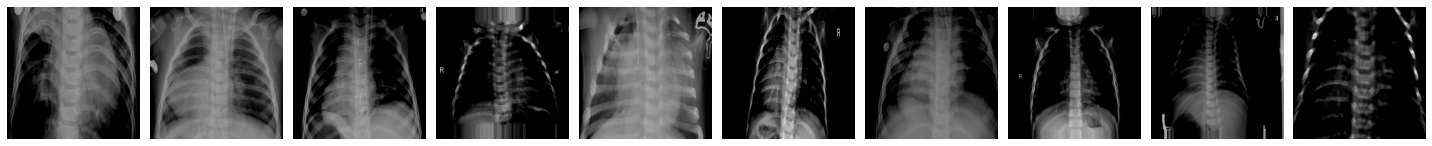

In [ ]:
plotimg(next(trainImages)[0])

In [ ]:
modelResNet152 = ResNet152V2(include_top=False, input_shape=(512, 512, 3), weights='imagenet')
for layer in modelResNet152.layers:
  layer.trainable = False
x = Flatten()(modelResNet152.output)
output = Dense(2, activation='softmax')(x)

modelResNet152 = Model(inputs=modelResNet152.inputs, outputs=output)

opt = keras.optimizers.Adam()
modelResNet152.compile(optimizer=opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy',
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC(multi_label = True),
                        'mse'])

In [ ]:
history = modelResNet152.fit(trainImages,
                    epochs=15, 
                    validation_data=testImages,
                    steps_per_epoch=len(trainImages),
                    validation_steps=len(testImages),
                    callbacks=[early_stopping,lr],
                    verbose=True)

Epoch 1/15
163/163 [==============================] - 382s 2s/step - loss: 3.7242 - accuracy: 0.9264 - recall_1: 0.9264 - auc_1: 0.9115 - mse: 0.0718 - val_loss: 8.3464 - val_accuracy: 0.8846 - val_recall_1: 0.8846 - val_auc_1: 0.8872 - val_mse: 0.1147 - lr: 0.0010
Epoch 2/15
163/163 [==============================] - 357s 2s/step - loss: 2.2490 - accuracy: 0.9511 - recall_1: 0.9511 - auc_1: 0.9414 - mse: 0.0481 - val_loss: 10.0344 - val_accuracy: 0.8814 - val_recall_1: 0.8814 - val_auc_1: 0.8572 - val_mse: 0.1167 - lr: 0.0010
Epoch 3/15
163/163 [==============================] - 366s 2s/step - loss: 2.1446 - accuracy: 0.9574 - recall_1: 0.9574 - auc_1: 0.9497 - mse: 0.0419 - val_loss: 7.8558 - val_accuracy: 0.8990 - val_recall_1: 0.8990 - val_auc_1: 0.8854 - val_mse: 0.1002 - lr: 0.0010
Epoch 4/15
163/163 [==============================] - 365s 2s/step - loss: 2.5070 - accuracy: 0.9582 - recall_1: 0.9582 - auc_1: 0.9488 - mse: 0.0411 - val_loss: 17.9890 - val_accuracy: 0.8446 - val_re

In [ ]:
score = modelResNet152.evaluate(testImages)

20/20 [==============================] - 12s 556ms/step - loss: 8.8375 - accuracy: 0.9151 - recall_1: 0.9151 - auc_1: 0.9016 - mse: 0.0844


Text(0.5, 1.0, 'Accuracy Evolution')

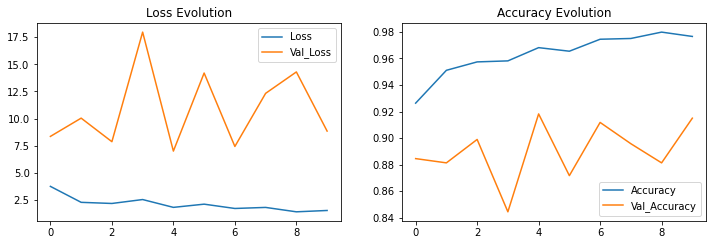

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('EVALUATION OF VGG19')

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
predictions = modelResNet152.predict(predImages)
predLabels = getPredLabelsCategorical(predictions)

In [ ]:
predLabels

In [ ]:
real_labels = [('PNEUMONIA' if i == 1 else 'NORMAL') for i in testImages.classes]


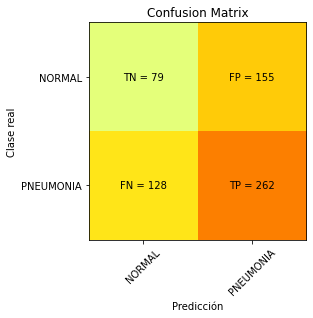

In [ ]:

cm = confusion_matrix(real_labels, predLabels)

matrixConfusion(cm)

##Extra

In [ ]:
real_labels = [('PNEUMONIA' if i == 1 else 'NORMAL') for i in testImages.classes]


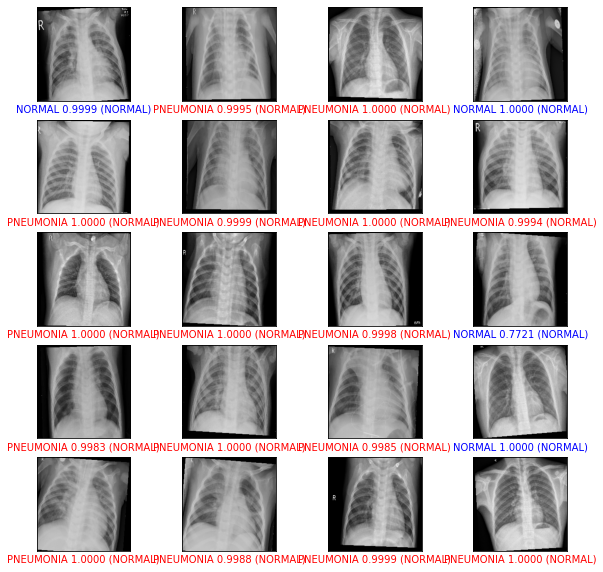

In [ ]:
plt.figure(figsize=(10,10))
for index_image in range(20):
  plt.subplot(5, 4, index_image+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(testImages[0][0][index_image])
  predicted_label = prediction_labels[index_image]
  real_label= real_labels[index_image]
  color= 'blue' if predicted_label == real_label else 'red'
  plt.xlabel(f'{predicted_label} {np.max(predictions[index_image]):.4f} ({real_label})', color=color)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(real_labels, prediction_labels)

In [ ]:
cm

array([[ 66, 168],
       [ 86, 304]])

In [ ]:
accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy
print(accuracy, misclass)

0.5625 0.4375


#Generar imagenes usando CNN (GAN) 

In [ ]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.cifar10.load_data() #sparse categorical crossentropy
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.1,stratify=Y_train) #stratify es equitativo

In [ ]:
X_train = np.concatenate([X_train, X_test])
Y_train = np.concatenate([Y_train, Y_test])

In [ ]:
X_train.shape

(60000, 32, 32, 3)

In [ ]:
batch_size = 128
num_channels = 3
num_classes = 10
image_size = 32
latent_dim = 128

In [ ]:
def norm_images(data):
  image = data['image']
  return image/255

In [ ]:
images = tfds.load('cifar10', split='train')
images=images.map(norm_images)
images=images.cache()
images=images.shuffle(50000)
images=images.batch(batch_size)
images=images.prefetch(64)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompletePH2KDS/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompletePH2KDS/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
#calcular el numero de canales de entrada para el generador y discriminador
generatorInput_channels = latent_dim + num_classes
discriminatorInpuut_channels = num_channels + num_classes 

**Crear la GAN condicional**

Esta nos permite decirle especificamente que clase de imagen queremos que genere

In [ ]:
#Generator
def GeneratorModel():
  model = Sequential()

  n_nodes = 256 * 4 * 4
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 256)))
  #  8x8
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # 16x16
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #  32x32
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))

  return model

def DiscriminatorModel():
  model = Sequential()

  model.add(Conv2D(32, 4, strides=(2,2),padding='same', input_shape=(32,32,3)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, 4, strides=(1,1), padding='same'))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, 4))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.2))

  model.add(Conv2D(256, 4))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dropout(0.25))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
generador = GeneratorModel()
discriminador = DiscriminatorModel()

In [ ]:
generador.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 4096)              528384    
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 8, 8, 128)        524416    
 ranspose)                                                       
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 16, 16, 128)      262272    
 Transpose)                                           

In [ ]:
discriminador.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 16, 16, 32)        1568      
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 16, 16, 32)        0         
                                                                 
 dropout_15 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 128)       65664     
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 dropout_16 (Dropout)        (None, 16, 16, 128)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 13, 13, 128)      

In [ ]:
disc_optimizer = keras.optimizers.Adam(learning_rate=0.0003)
gen_optimizer = keras.optimizers.Adam(learning_rate=0.0003)
discriminator_loss_fn = keras.losses.BinaryCrossentropy()
generator_loss_fn = keras.losses.()

In [ ]:
class ConditionalGAN(keras.Model):
  def __init__(self, discriminator, generator, *args, **kwargs):
      super().__init__(*args, **kwargs)
      self.discriminator = discriminator
      self.generator = generator
      self.latent_dim = latent_dim
      self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
      self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

  @property
  def metrics(self):
      return [self.gen_loss_tracker, self.disc_loss_tracker]

  def compile(self, disc_optimizer, gen_optimizer, generator_loss_fn, discriminator_loss_fn, *args, **kwargs):
      super().compile(*args, **kwargs)
      self.d_optimizer = disc_optimizer
      self.g_optimizer = gen_optimizer
      self.generator_loss_fn = generator_loss_fn
      self.discriminator_loss_fn = discriminator_loss_fn

  def train_step(self, data):
    real_images = data
    fake_images = self.generator(tf.random.normal((batch_size,latent_dim,1)), training=False)

    #entrenar el discriminador
    with tf.GradientTape() as d_tape:
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

      #crear las labels para los datos ingresados
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

      #crear ruido para valancear el entrenamiento junto con el generador
      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis=0)

      #calcular loss
      total_d_loss = self.discriminator_loss_fn(y_realfake, yhat_realfake)

    #aplicar backprop
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_optimizer.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    #entrenar el generador
    with tf.GradientTape() as g_tape:
      gen_images = self.generator(tf.random.normal((batch_size,latent_dim,1)), training=True)

      #crear las labels predecidas
      predicted_labels = self.discriminator(gen_images, training=False)

      #calcular loss - este paso se hace con truco para falsificar el discriminador y mejorar el entrenamiento en conjunto
      total_g_loss = self.generator_loss_fn(tf.zeros_like(predicted_labels), predicted_labels)

    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_optimizer.apply_gradients(zip(ggrad,self.generator.trainable_variables))


    return {"d_loss":total_d_loss,  "g_loss":total_g_loss}


In [ ]:
#Generar un callback
class ModelMonitor(Callback):
  def __init__(self, num_img=3, latent_dim=128):
      super().__init__()
      self.num_img = num_img
      self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
      random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
      generated_images = self.model.generator(random_latent_vectors)
      generated_images *= 255
      generated_images.numpy()
      for i in range(self.num_img):
        img = array_to_img(generated_images[i])
        img.save(os.path.join('images', f'generated_image_{epoch}_{i}.png'))

In [ ]:
del firstGAN

In [ ]:
firstGAN = ConditionalGAN(discriminador, generador)
firstGAN.compile(disc_optimizer, gen_optimizer, generator_loss_fn, discriminator_loss_fn)

In [ ]:
history = firstGAN.fit(images, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
 98/391 [======>.......................] - ETA: 13s - d_loss: 3.5998 - g_loss: 5.3025e-04

KeyboardInterrupt: ignored

# Test

Pa ver si es que soy yo el que no se de AI

In [ ]:
(input_train, target_train), (input_test, target_test) = keras.datasets.mnist.load_data()


11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
input_train.shape

(60000, 28, 28)

In [ ]:
#para pasarlo a one hot encoded
from sklearn.preprocessing import LabelBinarizer

In [ ]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar100.load_data()
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [ ]:
#Para pasarlas de [Pred] a one hot encoded [0,0,Pred,0,0,...,num_clases]
label_binarizer = LabelBinarizer()
Y_train = label_binarizer.fit_transform(Y_train)
Y_test = label_binarizer.fit_transform(Y_test)

In [ ]:
#sparse puede ser [[pred],[pred],...] o [pred,pred,pred,...]
Y_train = Y_train.reshape(-1)
Y_test = Y_test.reshape(-1)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=10)

In [ ]:
def createModel8(model):
  model.add(Conv2D(32,kernel_size=(2,2), activation='relu', padding='same', input_shape=(32,32,3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64,(2,2), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64,(2,2), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(100, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy',
                        ])



In [ ]:
modelTest = Sequential()
createModel8(modelTest)
#modelTest.summary()
#X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, train_size=0.8, stratify=Y_train)

In [ ]:
history = modelTest.fit(X_train, Y_train,
                    epochs=30,
                    batch_size=128, 
                    validation_split=0.2,
                    steps_per_epoch=300,
                    callbacks=[early_stopping,lr],
                    verbose=True)

In [ ]:
score = model.evaluate(input_test, target_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 7.988263130187988 / Test accuracy: 0.009999999776482582


# Lo mismo con pytorch

In [ ]:
from torch import optim
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader


import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Red Neuronal

In [ ]:
class ModelCifar(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3) # (in_channels, out_channels, kernel_size)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(16, 32, 3)
    self.lin1  = nn.Linear(32 * 6 * 6, 128)
    self.lin2 = nn.Linear(128, 64)
    self.out = nn.Linear(64, 10)
    self.act = nn.ReLU() 

  def forward(self, x):
    x = self.conv1(x)
    x = self.act(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.act(x)
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = self.act(self.lin1(x))
    x = self.act(self.lin2(x))
    x = self.out(x)
    return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

testmodel = ModelCifar()

testmodel.to(device)

lossfunc = nn.CrossEntropyLoss()
opt = optim.Adam(testmodel.parameters(), lr=0.001)


train model

In [ ]:
lossesMat, accuracies = [], []
for epoch in range(30):
  losses = 0.0
  for i, data in enumerate(trainloader, 0):
    #input, labels = data #cpu
    inputs, labels = data[0].to(device), data[1].to(device) #gpu

    opt.zero_grad()

    outputs = testmodel(inputs)

    loss = lossfunc(outputs, labels)
    loss.backward()

    cat = torch.argmax(outputs, 1)
    acc = (cat == labels).float().mean()

    opt.step()




    losses += loss.item()
    lossesMat.append(loss)
    accuracies.append(acc)
    if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {losses / 2000:.3f}')
            losses = 0.0

[1,  2000] loss: 1.554  accuracy: 0.3125
[2,  2000] loss: 1.110  accuracy: 0.875
[3,  2000] loss: 0.940  accuracy: 0.75
[4,  2000] loss: 0.822  accuracy: 0.875
[5,  2000] loss: 0.741  accuracy: 0.625
[6,  2000] loss: 0.670  accuracy: 0.75
[7,  2000] loss: 0.605  accuracy: 1.0
[8,  2000] loss: 0.562  accuracy: 0.75
[9,  2000] loss: 0.514  accuracy: 0.875
[10,  2000] loss: 0.464  accuracy: 1.0
[11,  2000] loss: 0.427  accuracy: 0.875
[12,  2000] loss: 0.390  accuracy: 0.875
[13,  2000] loss: 0.354  accuracy: 0.9375
[14,  2000] loss: 0.319  accuracy: 0.8125
[15,  2000] loss: 0.293  accuracy: 0.8125
[16,  2000] loss: 0.269  accuracy: 0.9375
[17,  2000] loss: 0.248  accuracy: 0.75
[18,  2000] loss: 0.231  accuracy: 0.9375
[19,  2000] loss: 0.212  accuracy: 1.0
[20,  2000] loss: 0.204  accuracy: 1.0
[21,  2000] loss: 0.186  accuracy: 0.8125
[22,  2000] loss: 0.184  accuracy: 0.9375
[23,  2000] loss: 0.173  accuracy: 0.9375
[24,  2000] loss: 0.162  accuracy: 0.875
[25,  2000] loss: 0.152  acc

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images, labels = images.to(device), labels.to(device) #gpu

outputs = testmodel(images)


_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(16)))
print('Real: ', ' '.join(f'{classes[labels[j]]:5s}'
                              for j in range(16)))

Predicted:  cat   ship  car   plane deer  frog  car   bird  cat   car   plane truck dog   horse truck ship 
Real:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship 


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:

        #images, labels = data #cpu
        images, labels = data[0].to(device), data[1].to(device) #gpu
        # calculate outputs by running images through the network
        outputs = testmodel(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 67 %


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0
